# Working with RTIs
Tori, this python notebook is meant to help you play with RTIs, including: 
* Plotting
* Manipulating
* Extracting amplitude/phase from a single RTI plot

In the `.zip` file I provided, you'll find a bunch of 15 second RTIs to work with. Some of these contain meteors, some contain planes, some both, some don't have any significant reflectors at all. The `.rti` files I've provided are really pickled python objects, which is like saving the variables in a python workspace to a file. 

Unzip the zip file to the same directory as this notebook, and we can start by seeing how many files I've provided. 

In [1]:
import glob # A common system tool for finding and parsing files 
data_dir = './rti_examples' # The name of the folder with the files  
rti_filenames = glob.glob(f'{data_dir}/*.rti') # Finding all files in the folder that end in .rti
num_files = len(rti_filenames)
print(f'Found {num_files:.0f} RTI files.')

Found 1 RTI files.


Let's play around with one. I'll choose one that I know contain both a plane and a meteor.

Cool noise: './rti_examples\\RTI_zephyrtx3_zephyrrx2_1678326201_15s.rti'

In [2]:
import pickle # For loading files

file_name = 'RTI_zephyrtx3_zephyrrx2_1678336626_15s.rti'
with open(f'{data_dir}/{file_name}', "rb") as f:
        rti_xarray = pickle.load(f)
print(rti_xarray)

<xarray.DataArray (tx_rx_channel_pair: 12, doppler_hz: 1, gate: 1000, time: 3000)> Size: 288MB
array([[[[-2373.932    -353.95853j ,  1627.0337  +1117.9836j  ,
            988.01215  -693.04364j , ...,   889.9681  -1063.0012j  ,
           -728.94434   +43.95805j , -2558.9473   -779.98846j ],
         [-1878.0083  -1971.9729j  , -1812.9425   -767.9685j  ,
          -2733.9377    +30.987822j, ...,  1281.9934  +5168.896j   ,
          -4510.9365  +1779.9711j  , -2053.0083  +2615.943j   ],
         [-2073.9966   +567.9576j  ,  2842.922   +1807.957j   ,
          -1686.0175  -2484.9578j  , ..., -2181.9421  +2765.0403j  ,
          -1933.0431   +598.0198j  , -2814.9873  +3185.9905j  ],
         ...,
         [  334.0001  +1669.9915j  , -1896.8877   +353.96094j ,
            172.05896 +2316.8994j  , ...,  1679.9557  -1078.9794j  ,
           -129.00204 +1689.9677j  , -1932.9631  +1081.9556j  ],
         [  863.99115 -2661.9275j  , -1755.0023   -901.979j   ,
           -849.98285  -974.94507j 

You'll see that the RTI is an `xarray` object. This is a tool that gives some information about its contents, similar to a pandas array, while still being fairly lightweight, like a numpy array. You can think about it like an annotated pandas array, where each dimention is labeled, and it can include some extra metadata. 

This is highly dimentional data: each RTI plot we've seen is a 3D plot (time, range, and color intensity), but that's just for a single pair. We also have the dimention of tx-rx pair, as well as the Doppler shift. Don't worry about Doppler for now, we'll just set it to zero. 

There's a lot of data here, so let's figure out what to focus on:
* **Tx-rx channel pair**: Let's just average them all and see what happens. 
* **Doppler**: we're ignoring that for now, setting the Doppler to 0.
* **Time**: we only have 15s of data, so let's look at the entire time series.
* **Gate**: let's focus on gates that contain meteors or planes. 

So, which range gates are imporant? Meteors generally occur at 70-110 km, and we generally ignore meteors below 20$\^circ$ elevation. Looking at John's thesis, we found that each range gate is 1.5 km wide. Let's find the maximum range to a useful meteor, and see what the maximum useful range gate would be. 

In [3]:
import numpy as np 

ht_max = 110e3 # [m] 
gate_wd = 1.5e3 # [m] 
el_min_deg = 20 # [deg] 
R_max = ht_max / np.sin(np.deg2rad(el_min_deg))
max_gate = int(R_max // gate_wd)
print(f'Max gate for a meteor at {ht_max * 1e-3:.0f} km \
and {el_min_deg:.0f} deg. elevation is gate {max_gate:.0f}.')

Max gate for a meteor at 110 km and 20 deg. elevation is gate 214.


We can compare this result to the expected maximum range gate of a plane:

In [4]:
ht_max_plane = 12e3 # [m]. This is about 40,000 ft 
R_max_plane = ht_max_plane / np.sin(np.deg2rad(el_min_deg))
max_gate_plane = int(R_max_plane // gate_wd)
print(f'Max gate for a plane at {ht_max_plane * 1e-3:.0f} km \
and {el_min_deg:.0f} deg. elevation is gate {max_gate_plane:.0f}.')

Max gate for a plane at 12 km and 20 deg. elevation is gate 23.


Let's plot the average of all the channels over the first 250 range gates and see what happens. 

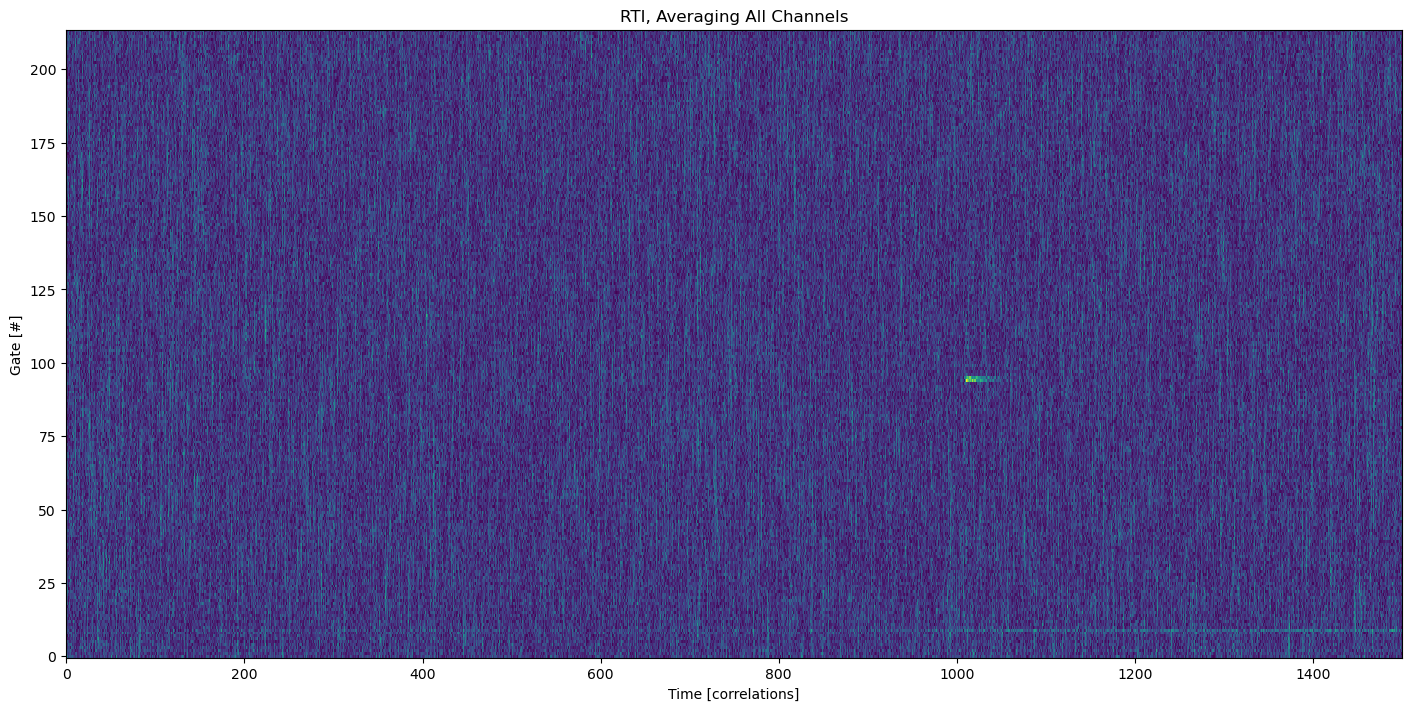

In [5]:
import matplotlib.pyplot as plt # Plotting 
from matplotlib.ticker import MaxNLocator

# RTI diagram
rti_array = rti_xarray.values[:, 0, :max_gate, :1500]
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
rti_for_plot = np.abs(rti_array.mean(0))  # Collapse Doppler Dimension, mean across channels

ax.imshow(rti_for_plot, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

There's clearly something there, and maybe a plane, but it's hard to tell. I'm going to use a trick called [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to use the different information that all the channels provide to try to maximize any interesting features. 

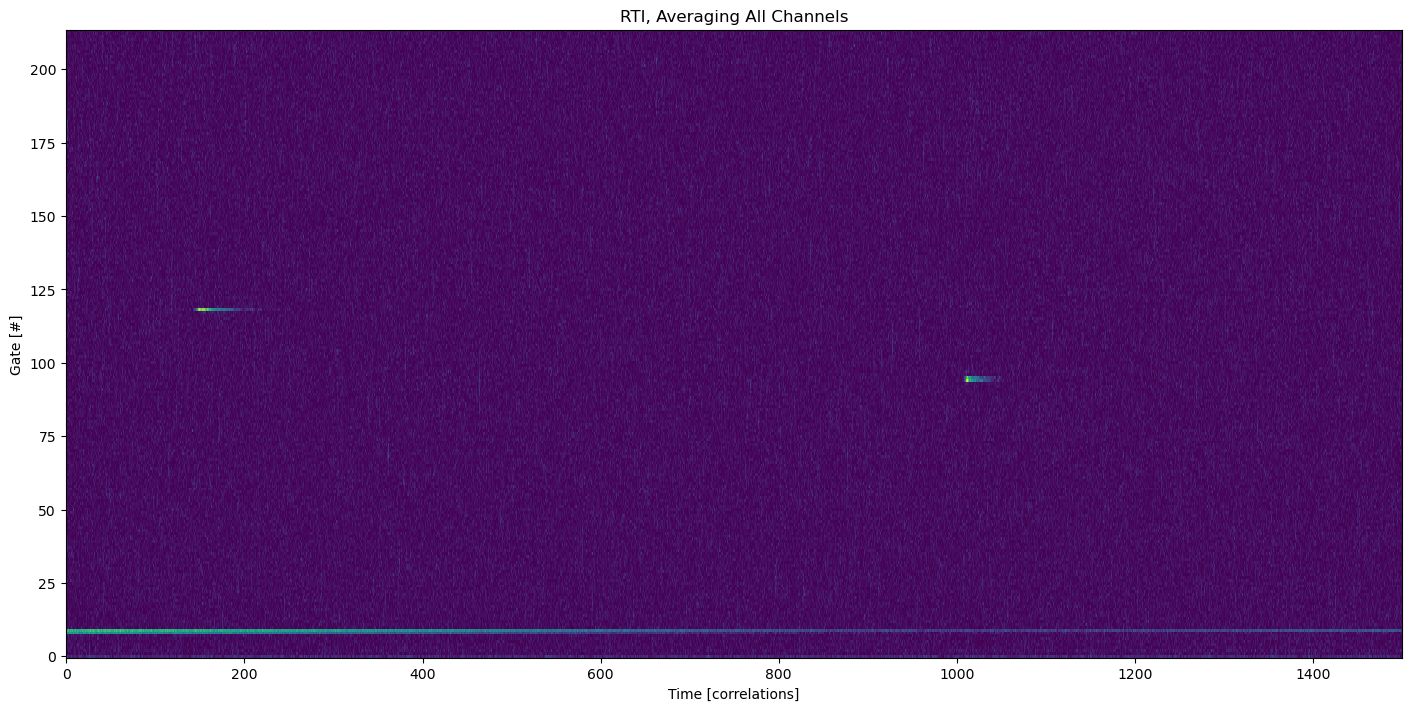

In [6]:
from sklearn.decomposition import PCA

# Performing PCA 
n_ch, n_gates, n_times = rti_array.shape
X = np.moveaxis(rti_array, 0, -1).reshape(-1, n_ch)
X = abs(X)
pca = PCA(n_components=1)
pca.fit(X)
rti_PCA = pca.fit_transform(X)
rti_PCA = np.reshape(rti_PCA, (n_gates, n_times, 1)).squeeze()

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
pca_for_plot = np.abs(rti_PCA[:, :])
ax.imshow(pca_for_plot, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

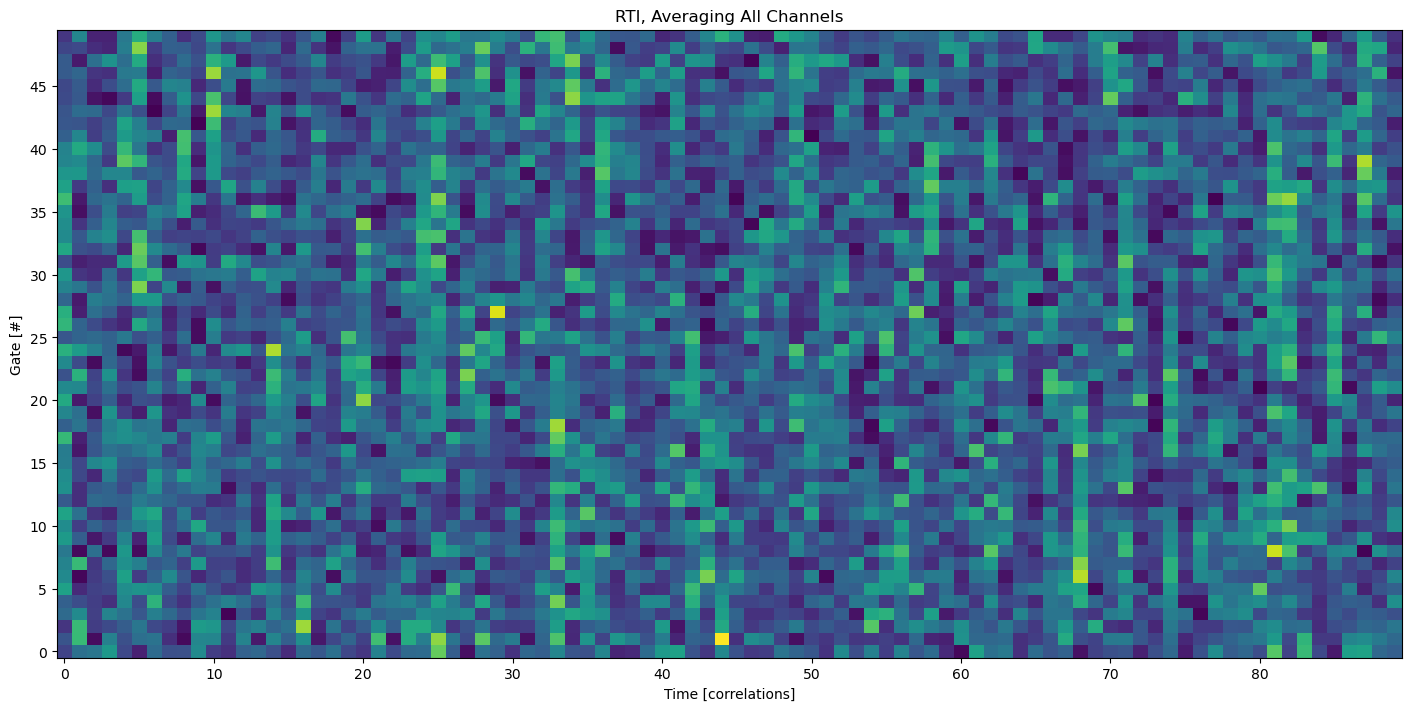

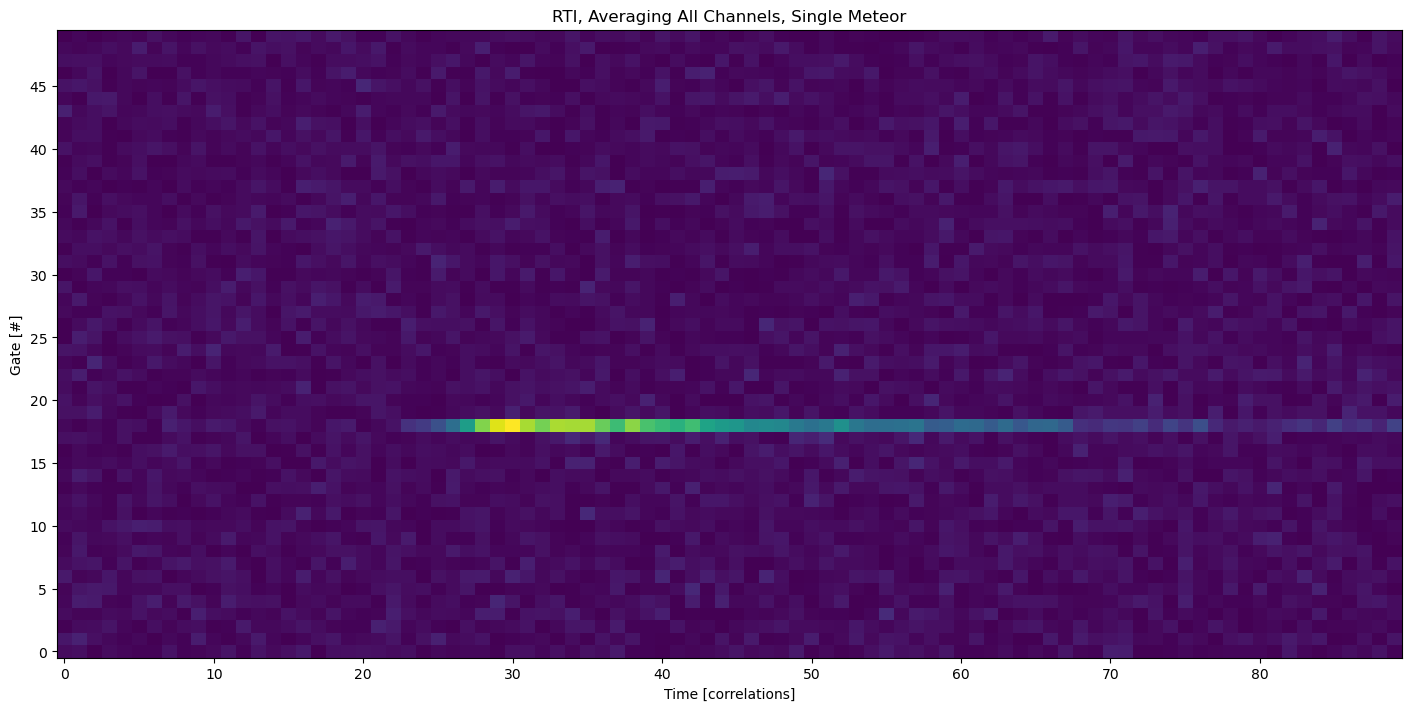

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt # Plotting 
from matplotlib.ticker import MaxNLocator

# RTI diagram
rti_array = rti_xarray.values[:, 0, 100:150, 120:210]
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
rti_for_plot = np.abs(rti_array.mean(0))  # Collapse Doppler Dimension, mean across channels

ax.imshow(rti_for_plot, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

# Performing PCA 
n_ch, n_gates, n_times = rti_array.shape
X = np.moveaxis(rti_array, 0, -1).reshape(-1, n_ch)
X = abs(X)
pca = PCA(n_components=1)
pca.fit(X)
rti_PCA = pca.fit_transform(X)
rti_PCA = np.reshape(rti_PCA, (n_gates, n_times, 1)).squeeze()

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
pca_for_plot = np.abs(rti_PCA[:, :])
ax.imshow(pca_for_plot, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels, Single Meteor')
plt.show()

In [8]:
n_times

90

Much better. I couldn't even see the plane in the early time stamps, and it looks like a whole new meteor appeared! Pretty cool. Let's see if we can't use the zephyr repo to do some of this plotting for us. 

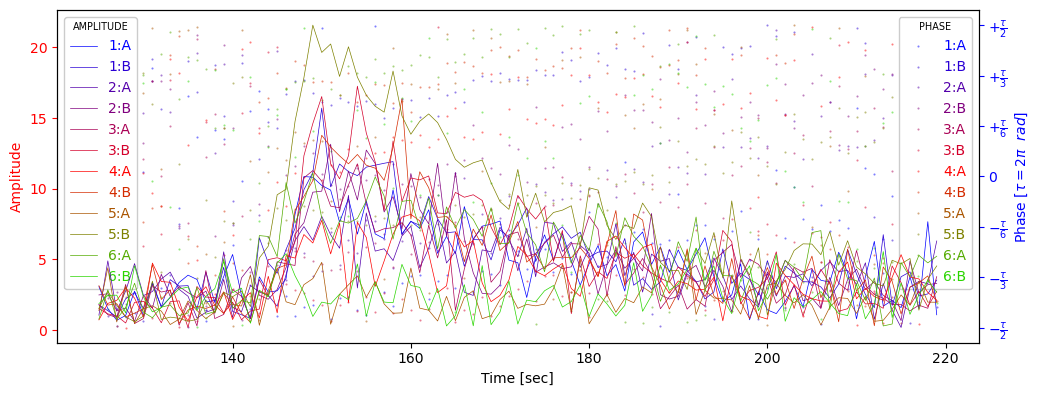

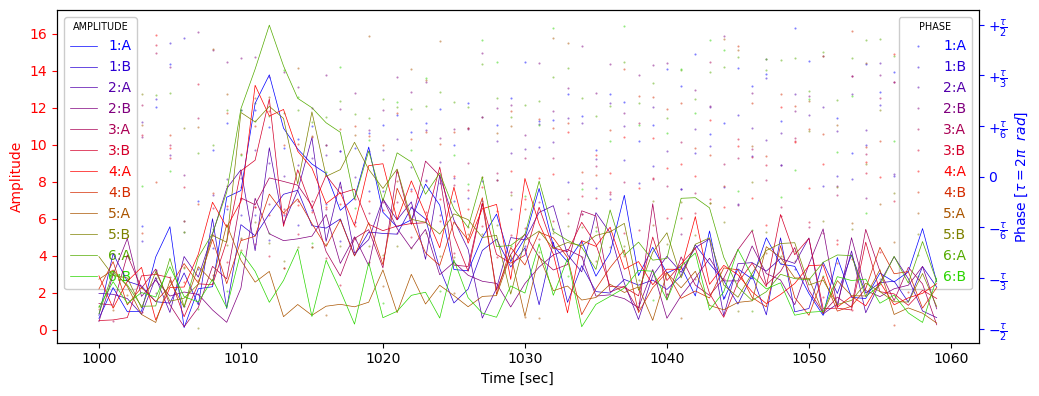

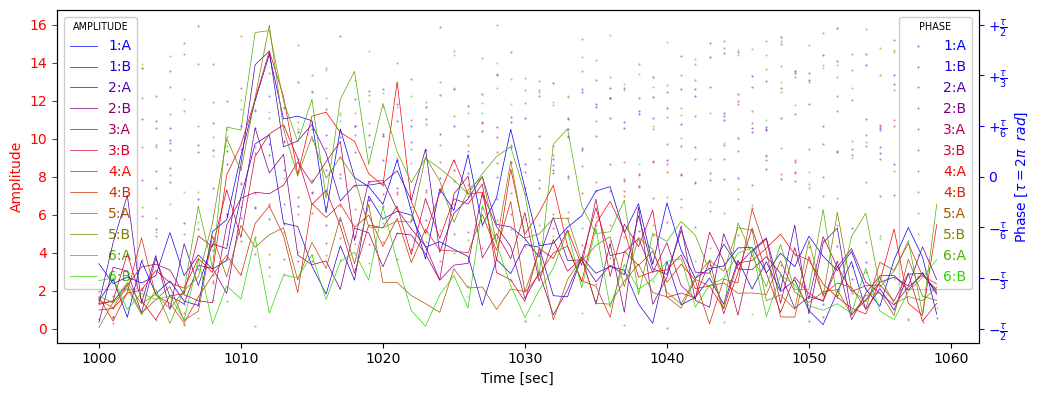

In [9]:
import zephyr

#1st Metior
met_gate1 = 118 # or 95
data1 = rti_xarray.values[:, 0, met_gate1, 125:220].T;

# Plotting a single range gate
zephyr.plotting.plt_CEV(data1, np.arange(125,220));

#2nd Metior
met_gate2 = 95 # or 95
data2 = rti_xarray.values[:, 0, met_gate2, 1000:1060].T;

# Plotting a single range gate
zephyr.plotting.plt_CEV(data2, np.arange(1000,1060));

#2nd metior plot for detecged range gate

met_gate3 = 94 # or 95
data3 = rti_xarray.values[:, 0, met_gate3, 1000:1060].T;

# Plotting a single range gate
zephyr.plotting.plt_CEV(data3, np.arange(1000,1060));

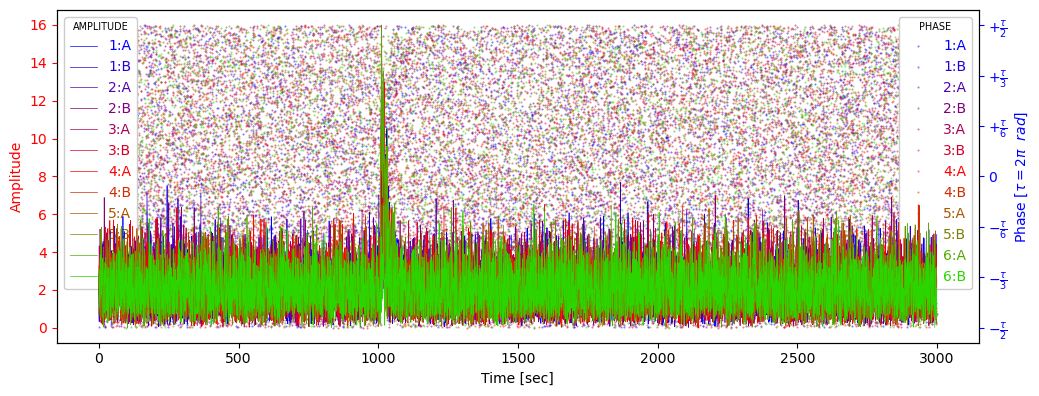

In [10]:
#Metior over full time (For Poster)
met_gate1 = 94 # 94, 95, or 118
data1 = rti_xarray.values[:, 0, met_gate1, :].T;

# Plotting a single range gate
zephyr.plotting.plt_CEV(data1, np.arange(0,3000));

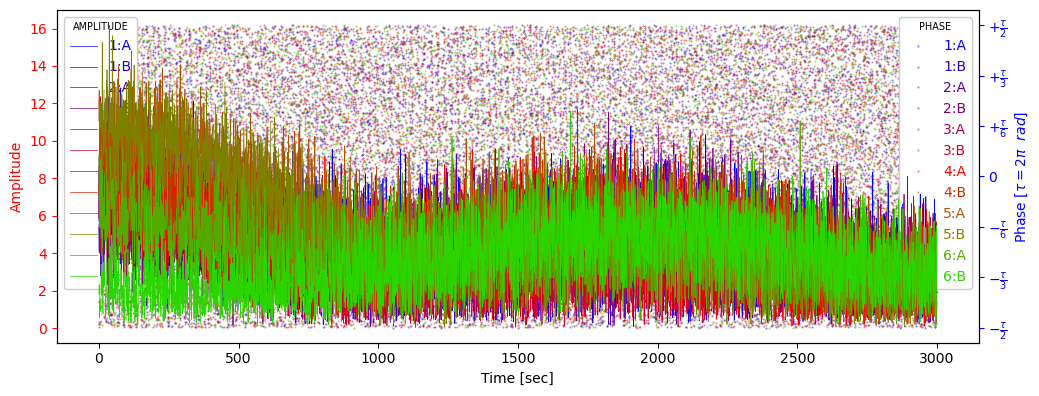

In [11]:
#Plane
met_gate1 = 9 # Plane seems to be in 8, 9
data1 = rti_xarray.values[:, 0, met_gate1, :].T;

# Plotting a single range gate
zephyr.plotting.plt_CEV(data1, np.arange(0,3000)); #Semmi colon supresses print statements.

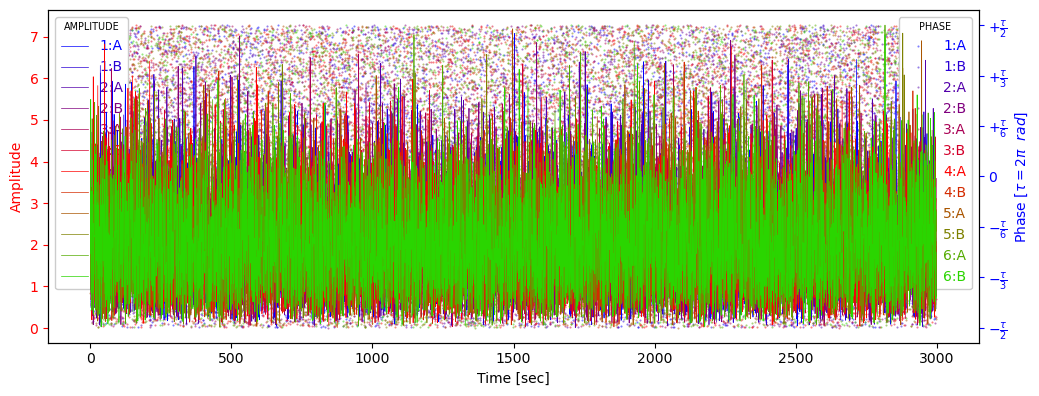

In [12]:
#Empty (For Reference)
met_gate1 = 150 # Plane seems to be in 8, 9
data1 = rti_xarray.values[:, 0, met_gate1, :].T;

# Plotting a single range gate
zephyr.plotting.plt_CEV(data1, np.arange(0,3000));

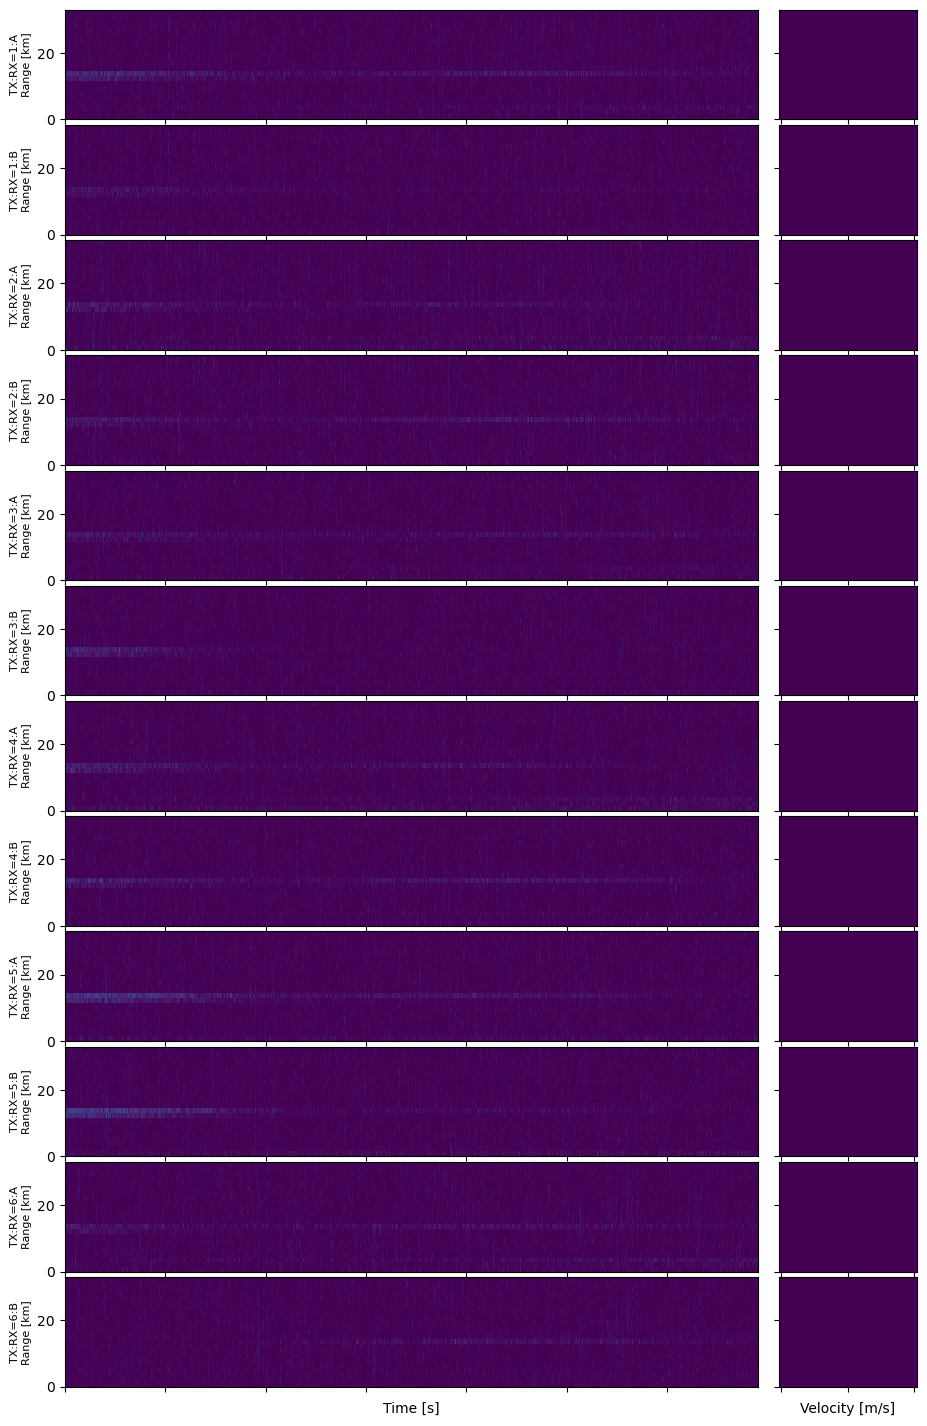

In [13]:
# Plotting each channel's RTI
rti_plt = rti_xarray.values[:, 0, :max_gate_plane, :].T
rti_plt = np.moveaxis(rti_plt, 1, 0)
zephyr.plotting.plt_RangeTimeMatrix(rti_plt, sample_rate = 200e3, center_frequency=31.25e6);

In [14]:
type(rti_array)

numpy.ndarray

In [15]:
from zephyr import detect_meteor

In [16]:
rti_xarray.values[:, 0, met_gate1, :].T

array([[ -170.0059 -3079.9246j ,  -305.97238+1444.9884j ,
         1164.0233 +4025.8625j , ..., -2823.9358  +881.0464j ,
        -1505.9501 +4903.9355j ,  -397.97763-1744.989j  ],
       [  582.9986 -3551.8572j ,  1184.9814 -2993.9365j ,
         -756.9661  +855.9346j , ..., -1324.9977 +2428.0103j ,
         1186.9794  +831.95807j,  -761.0559 -5439.876j  ],
       [ -457.9751  +185.01228j,  -893.0109 +3117.9346j ,
         -783.9701  -478.9903j , ..., -1454.9943 +2921.9612j ,
          839.98126 +165.02145j,  -680.9802 -2477.94j   ],
       ...,
       [ 2009.9283  +596.94904j,   146.9625  +433.9579j ,
         1115.9795 -1860.9557j , ...,  -313.00528 +332.02594j,
         -273.99258+1046.9873j , -1304.9996  +219.98036j],
       [  295.00424 +843.9566j ,  1203.0101 -1028.0084j ,
          522.963   -818.01294j, ..., -2428.95   +1483.9633j ,
         1828.9489 +1377.9719j ,  1810.9696  -236.04318j],
       [ -759.02136-1031.9653j ,  -525.0024  -573.9882j ,
         -582.9584 +1131.9788j

In [17]:
data2

array([[ 6.09006958e+02-8.69812546e+01j, -4.76939392e+02-6.16012451e+02j,
         1.47495349e+03-1.30098254e+03j,  1.07003403e+02+4.25990723e+02j,
         1.41097827e+03+1.08975883e+02j, -4.70144615e+01+4.97976868e+02j,
        -2.83695850e+03+6.76973328e+02j, -2.15298657e+03+4.67975830e+02j,
        -2.50697217e+03-1.08696082e+03j, -3.53894141e+03-1.76596973e+03j,
        -3.11004944e+02-8.08959656e+02j,  7.69028137e+02-9.39973389e+02j],
       [ 2.00792419e+03-1.07699243e+03j,  3.17191602e+03-2.61698096e+03j,
         8.83916321e+02-1.70100305e+03j,  1.78791748e+03-2.38897241e+03j,
        -1.31397156e+03-2.22973282e+02j, -2.54017120e+02-4.68979675e+02j,
         1.00596545e+03-5.86992371e+02j,  1.88397034e+03-3.16295361e+03j,
        -2.99796826e+03-1.20897949e+03j, -2.61793384e+03-1.31698474e+03j,
        -7.81982483e+02+3.01897192e+03j,  1.90000684e+03+1.77294812e+03j],
       [ 2.44000443e+02+9.43975159e+02j,  8.08031433e+02+2.49195093e+03j,
         1.40399268e+03+9.35868042e+

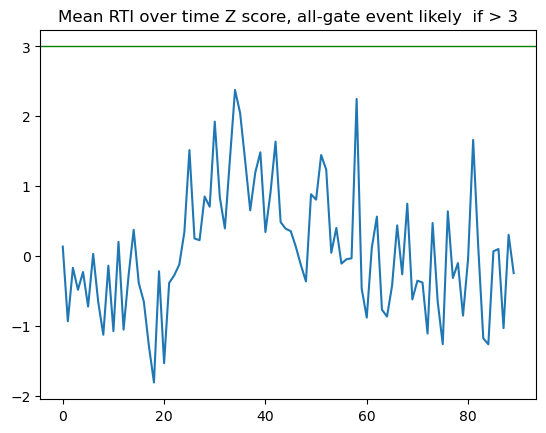

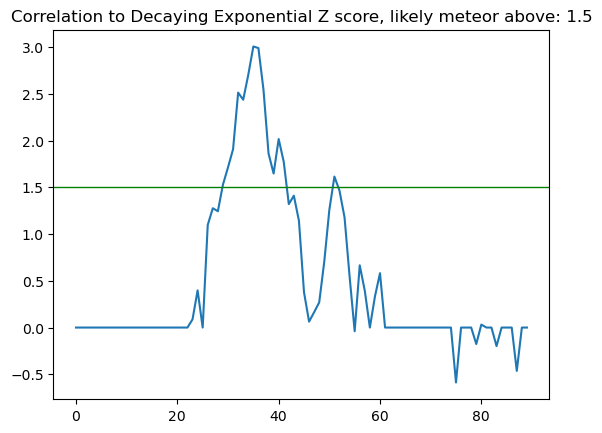

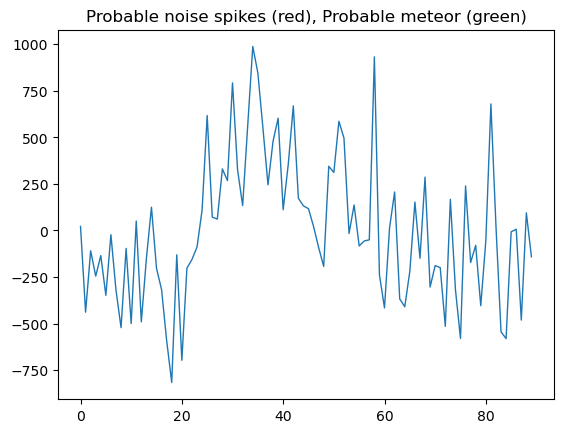

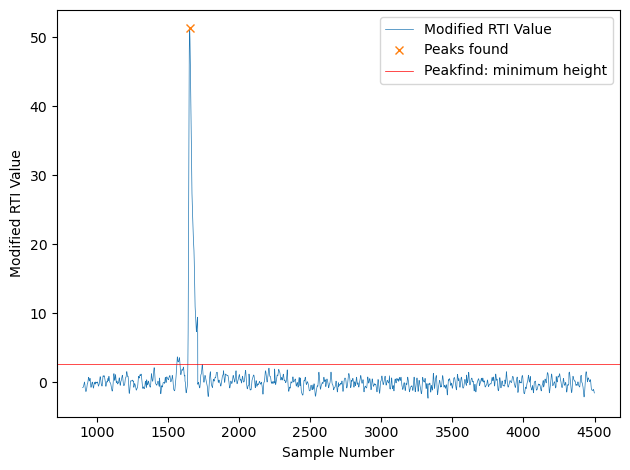

In [18]:
list_detections, img, list_dict_properties, list_peaks_idx_1D=detect_meteor(rti_PCA,optional_plots = ['det_diag','det_flat','']);
#I think that all I am concerned about is the list_detections, and possibly list-dict_proporties

In [19]:
list_detections

[(18, 33, 1653, 1668)]

<class 'numpy.ndarray'>


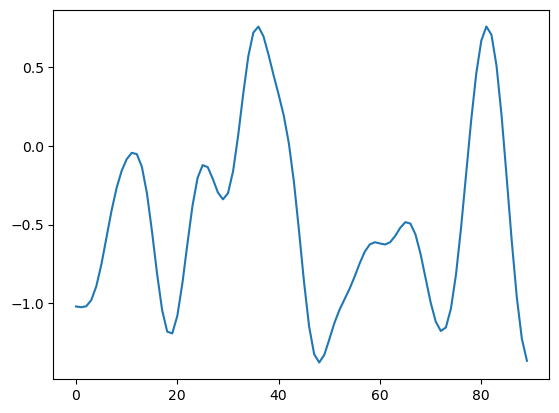

In [24]:
img.shape
print(type(img))
plt.plot(img[35,:])

In [21]:
list_dict_properties[0]

{'peak_heights': 51.283756256103516,
 'prominences': 52.93740653991699,
 'left_bases': 1450,
 'right_bases': 3329,
 'widths': 27.066415751060504,
 'width_heights': 24.81505298614502,
 'left_ips': 1645.518793530518,
 'right_ips': 1672.5852092815785}

In [22]:
type(list_peaks_idx_1D)

numpy.ndarray

In [23]:
detection1=list_detections[0]
detection2=list_detections[1]
type(detection1[1])

IndexError: list index out of range

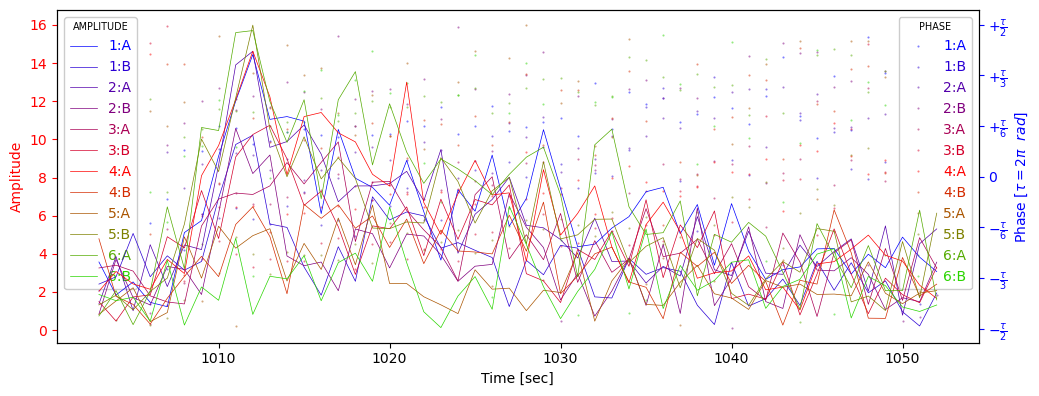

In [ ]:
#Print 1st detected metior
det1_gate = detection1[0] # Detected Gate
det1_mintime=int(detection1[1]-10)
det1_maxtime=int(detection1[1]+40)
det1_DATA = rti_xarray.values[:, 0, det1_gate, det1_mintime:det1_maxtime].T;

# Plotting a single range gate
zephyr.plotting.plt_CEV(det1_DATA, np.arange(det1_mintime,det1_maxtime));

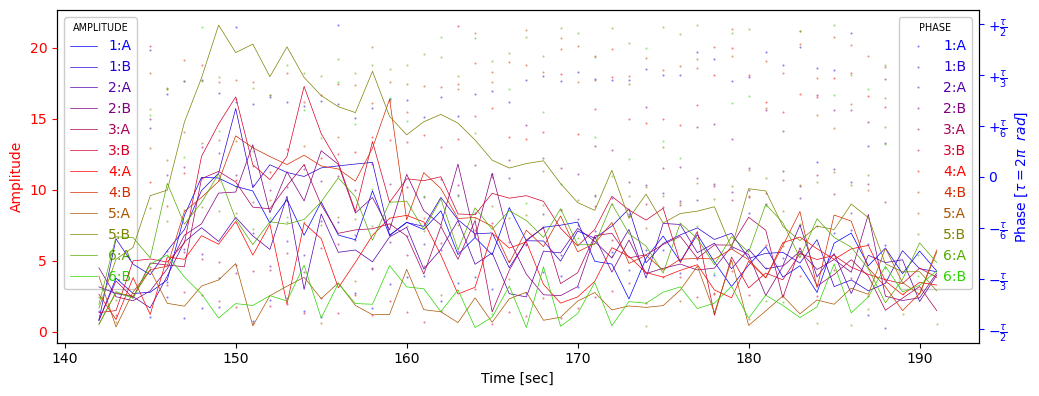

In [ ]:
#Print 1st detected metior
det2_gate = detection2[0] # Detected Gate
det2_mintime=int(detection2[1]-10)
det2_maxtime=int(detection2[1]+40)
det2_DATA = rti_xarray.values[:, 0, det2_gate, det2_mintime:det2_maxtime].T;

# Plotting a single range gate
zephyr.plotting.plt_CEV(det2_DATA, np.arange(det2_mintime,det2_maxtime));